<a href="https://colab.research.google.com/github/ShanmugapriyanManoharan/OpenCV-Deep-Learning/blob/master/Speedestimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to Unzip the folder from the google drive

In [1]:
from zipfile import ZipFile
filename = '/content/drive/My Drive/data.zip'

with ZipFile(filename, 'r') as zip1:
  zip1.extractall()
  print('done')

done


Required Functions (Model, Conver to Optical)

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, Reshape, BatchNormalization, ELU
from keras.optimizers import Adam
#from keras_radam import RAdam

In [0]:
def CNNModel():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, input_shape = (240, 320, 3), subsample=(2,2), init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), init = 'he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3, subsample = (1,1), init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample= (1,1), border_mode = 'valid', init = 'he_normal'))
    model.add(Flatten())
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal'))
    # model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal'))
    model.add(ELU())
    model.add(Dense(1, init = 'he_normal'))

    adam = Adam(lr=1e-4)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [0]:
def convertToOptical(prev_image, curr_image):

    prev_image_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
    curr_image_gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev_image_gray, curr_image_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # flow = cv2.calcOpticalFlowFarneback(prev_image_gray, curr_image_gray, None, 0.5, 2, 15, 2, 5, 1.2, 0)

    hsv = np.zeros_like(prev_image)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 255
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_image_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return flow_image_bgr

Training the Model

In [0]:
import cv2
import numpy as np
import os, sys
from os import listdir
from os.path import join
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, Reshape, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import Image

In [0]:
PATH_DATA_FOLDER = './data/'
PATH_TRAIN_LABEL = PATH_DATA_FOLDER +  'train.txt'
PATH_TRAIN_IMAGES_FOLDER = PATH_DATA_FOLDER +  'train_images/'
PATH_TRAIN_IMAGES_FLOW_FOLDER = PATH_DATA_FOLDER +  'train_images_flow/'

TYPE_FLOW_PRECOMPUTED = 0
TYPE_ORIGINAL = 1

BATCH_SIZE = 128
EPOCH = 50

MODEL_NAME = 'CNNModel_flow'

In [0]:
def prepareData(labels_path, images_path, flow_images_path, type=TYPE_FLOW_PRECOMPUTED):
    num_train_labels = 0
    train_labels = []
    train_images_pair_paths = []

    with open(labels_path) as txt_file:
        labels_string = txt_file.read().split()

        for i in range(4, len(labels_string)):
            speed = float(labels_string[i])
            train_labels.append(speed)

            if type == TYPE_FLOW_PRECOMPUTED:
                # Combine original and pre computed optical flow
                train_images_pair_paths.append( ( os.getcwd() + images_path[1:] + str(i)+ '.jpg',  os.getcwd() + flow_images_path[1:] + str(i-3) + '.jpg',   os.getcwd() + flow_images_path[1:] + str(i-2) + '.jpg',   os.getcwd() + flow_images_path[1:] + str(i-1) + '.jpg',  os.getcwd() + flow_images_path[1:] + str(i) + '.jpg') )
            else:
                # Combine 2 consecutive frames and calculate optical flow
                train_images_pair_paths.append( ( os.getcwd() + images_path[1:] + str(i-1)+ '.jpg',  os.getcwd() + images_path[1:] + str(i) + '.jpg') )

    return train_images_pair_paths, train_labels

In [0]:
def generatorData(samples, batch_size=32, type=TYPE_FLOW_PRECOMPUTED):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:

                combined_image = None
                flow_image_bgr = None

                if type == TYPE_FLOW_PRECOMPUTED:

                    # curr_image_path, flow_image_path = imagePath
                    # flow_image_bgr = cv2.imread(flow_image_path)
                    curr_image_path, flow_image_path1, flow_image_path2,flow_image_path3, flow_image_path4 = imagePath
                    flow_image_bgr = (cv2.imread(flow_image_path1) +cv2.imread(flow_image_path2) +cv2.imread(flow_image_path3) +cv2.imread(flow_image_path4) )/4

                    curr_image = cv2.imread(curr_image_path)
                    curr_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2RGB)

                else:
                    prev_image_path, curr_image_path = imagePath
                    prev_image = cv2.imread(prev_image_path)
                    curr_image = cv2.imread(curr_image_path)
                    flow_image_bgr = convertToOptical(prev_image, curr_image)
                    curr_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2RGB)


                combined_image = 0.1*curr_image + flow_image_bgr
                #CHOOSE IF WE WANT TO TEST WITH ONLY OPTICAL FLOW OR A COMBINATION OF VIDEO AND OPTICAL FLOW
                combined_image = flow_image_bgr

                combined_image = cv2.normalize(combined_image, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                combined_image = cv2.resize(combined_image, (0,0), fx=0.5, fy=0.5)

                # im = Image.fromarray(combined_image)
                # plt.imshow(im)
                # plt.show()

                images.append(combined_image)
                angles.append(measurement)

                # AUGMENTING DATA
                # Flipping image, correcting measurement and  measuerement

                images.append(cv2.flip(combined_image,1))
                angles.append(measurement)

            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

Total Images: 20396
Train samples: 16316
Validation samples: 4080
Training model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(240, 320,..., strides=(2, 2), kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), kernel_initializer="he_normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), kernel_initializer="he_normal")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer="he_normal")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_

Epoch 1/50
127/127 [==============================] - 695s 5s/step - loss: 38.0376 - val_loss: 13.6356
Epoch 2/50
127/127 [==============================] - 641s 5s/step - loss: 10.7661 - val_loss: 5.9155
Epoch 3/50
127/127 [==============================] - 639s 5s/step - loss: 6.0953 - val_loss: 3.9631
Epoch 4/50
127/127 [==============================] - 637s 5s/step - loss: 3.7755 - val_loss: 3.5543
Epoch 5/50
127/127 [==============================] - 641s 5s/step - loss: 2.8706 - val_loss: 2.1905
Epoch 6/50
127/127 [==============================] - 629s 5s/step - loss: 2.0742 - val_loss: 2.1192
Epoch 7/50
127/127 [==============================] - 626s 5s/step - loss: 1.7006 - val_loss: 1.7558
Epoch 8/50
127/127 [==============================] - 625s 5s/step - loss: 1.4229 - val_loss: 1.9032
Epoch 9/50
127/127 [==============================] - 635s 5s/step - loss: 1.2017 - val_loss: 1.5594
Epoch 10/50
127/127 [==============================] - 633s 5s/step - loss: 1.0571 - val

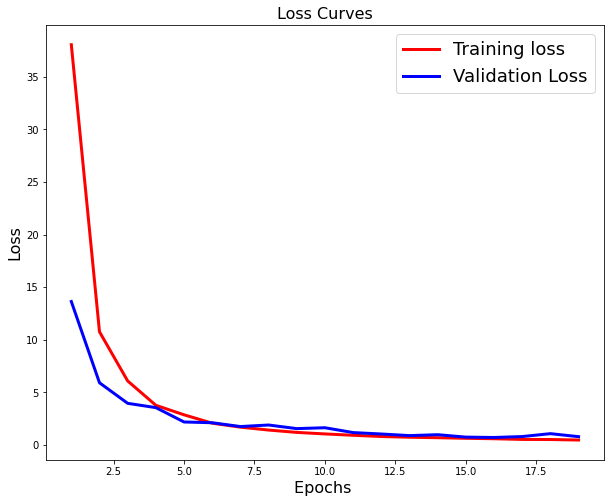

<Figure size 432x288 with 0 Axes>

In [12]:
if __name__ == '__main__':

    type_ = TYPE_FLOW_PRECOMPUTED   ## optical flow pre computed
    # type = TYPE_ORIGINAL

    train_images_pair_paths, train_labels =  prepareData(PATH_TRAIN_LABEL, PATH_TRAIN_IMAGES_FOLDER, PATH_TRAIN_IMAGES_FLOW_FOLDER, type=type_)

    samples = list(zip(train_images_pair_paths, train_labels))
    train_samples, validation_samples = train_test_split(samples, test_size=0.2)

    print('Total Images: {}'.format( len(train_images_pair_paths)))
    print('Train samples: {}'.format(len(train_samples)))
    print('Validation samples: {}'.format(len(validation_samples)))

    training_generator = generatorData(train_samples, batch_size=BATCH_SIZE, type=type_)
    validation_generator = generatorData(validation_samples, batch_size=BATCH_SIZE, type=type_)

    print('Training model...')

    model = CNNModel()

    callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best'+MODEL_NAME+'.h5', monitor='val_loss', save_best_only=True)]

    history_object = model.fit_generator(training_generator, samples_per_epoch= \
                     len(train_samples)//BATCH_SIZE, validation_data=validation_generator, \
                     validation_steps=len(validation_samples)//BATCH_SIZE, callbacks=callbacks, epochs=EPOCH, verbose=1)

    print('Training model complete...')

    print(history_object.history.keys())
    print('Loss')
    print(history_object.history['loss'])
    print('Validation Loss')
    print(history_object.history['val_loss'])


    plt.figure(figsize=[10,8])
    plt.plot(np.arange(1, len(history_object.history['loss'])+1), history_object.history['loss'],'r',linewidth=3.0)
    plt.plot(np.arange(1, len(history_object.history['val_loss'])+1), history_object.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()
    plt.savefig('graph.png')

Testing the model

In [0]:
import cv2
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

In [0]:
PATH_DATA_FOLDER = './data/'
PATH_TEST_LABEL = PATH_DATA_FOLDER +  'test.txt'
PATH_TEST_VIDEO = PATH_DATA_FOLDER + 'test.mp4'
PATH_TEST_VIDEO_OUTPUT = PATH_DATA_FOLDER + 'test_output.mp4'
PATH_COMBINED_TEST_VIDEO_OUTPUT = PATH_DATA_FOLDER + 'combined_test_output.mp4'
PATH_TEST_IMAGES_FOLDER = PATH_DATA_FOLDER +  'test_images/'
PATH_TEST_IMAGES_FLOW_FOLDER = PATH_DATA_FOLDER +  'test_images_flow/'

TYPE_FLOW_PRECOMPUTED = 0
TYPE_ORIGINAL = 1


MODEL_NAME = 'CNNModel_flow'
PRE_TRAINED_WEIGHTS = './best'+MODEL_NAME+'.h5'

In [0]:
def predict_from_video(video_input_path, original_video_output_path, combined_video_output_path):
    predicted_labels = []

    video_reader = cv2.VideoCapture(video_input_path)

    num_frames = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_size = (int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fps = int(video_reader.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #fourcc = 0x00000021
    video_writer = cv2.VideoWriter(original_video_output_path, fourcc, fps, frame_size)
    video_writer_combined = cv2.VideoWriter(combined_video_output_path, fourcc, fps, frame_size)

    t1 = time.time()
    ret, prev_frame = video_reader.read()
    hsv = np.zeros_like(prev_frame)

    video_writer.write(prev_frame)

    predicted_labels.append(0.0)

    flow_image_bgr_prev1 =  np.zeros_like(prev_frame)
    flow_image_bgr_prev2 =  np.zeros_like(prev_frame)
    flow_image_bgr_prev3 =  np.zeros_like(prev_frame)
    flow_image_bgr_prev4 =  np.zeros_like(prev_frame)


    font                   = cv2.FONT_HERSHEY_SIMPLEX
    place = (50,50)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    count =0
    while True:
        ret, next_frame = video_reader.read()
        if ret is False:
            break

        flow_image_bgr_next = convertToOptical(prev_frame, next_frame)
        flow_image_bgr = (flow_image_bgr_prev1 + flow_image_bgr_prev2 +flow_image_bgr_prev3 +flow_image_bgr_prev4 + flow_image_bgr_next)/4

        curr_image = cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB)

        combined_image_save = 0.1*curr_image + flow_image_bgr

        #CHOOSE IF WE WANT TO TEST WITH ONLY OPTICAL FLOW OR A COMBINATION OF VIDEO AND OPTICAL FLOW
        combined_image = flow_image_bgr
        # combined_image = combined_image_save

        combined_image_test = cv2.normalize(combined_image, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # plt.imshow(combined_image)
        # plt.show()

        #CHOOSE IF WE WANT TO TEST WITH ONLY OPTICAL FLOW OR A COMBINATION OF VIDEO AND OPTICAL FLOW
        # combined_image_test = cv2.resize(combined_image, (0,0), fx=0.5, fy=0.5)
        combined_image_test = cv2.resize(combined_image_test, (0,0), fx=0.5, fy=0.5)

        combined_image_test = combined_image_test.reshape(1, combined_image_test.shape[0], combined_image_test.shape[1], combined_image_test.shape[2])

        prediction = model.predict(combined_image_test)

        predicted_labels.append(prediction[0][0])

        # print(combined_image.shape, np.mean(flow_image_bgr), prediction[0][0])

        cv2.putText(next_frame, str(prediction[0][0]), place, font, fontScale,fontColor,lineType)
        cv2.putText(combined_image_save, str(prediction[0][0]), place, font, fontScale,fontColor,lineType)

        video_writer.write(next_frame)
        video_writer_combined.write(combined_image_save.astype('uint8'))

        prev_frame = next_frame
        flow_image_bgr_prev4 = flow_image_bgr_prev3
        flow_image_bgr_prev3 = flow_image_bgr_prev2
        flow_image_bgr_prev2 = flow_image_bgr_prev1
        flow_image_bgr_prev1 = flow_image_bgr_next

        count +=1
        sys.stdout.write('\rprocessed frames: %d of %d' % (count, num_frames))


    t2 = time.time()
    video_reader.release()
    video_writer.release()
    video_writer_combined.release()
    print(' Prediction completed !')
    print(' Time Taken:', (t2 - t1), 'seconds')

    predicted_labels[0] = predicted_labels[1]
    return predicted_labels

In [16]:
if __name__ == '__main__':

    model = CNNModel()
    model.load_weights(PRE_TRAINED_WEIGHTS)

    print('Testing model...')
    predicted_labels = predict_from_video(PATH_TEST_VIDEO,  PATH_TEST_VIDEO_OUTPUT, PATH_COMBINED_TEST_VIDEO_OUTPUT)

    with open(PATH_TEST_LABEL, mode="w") as outfile:
        for label in predicted_labels:
            outfile.write("%s\n" % str(label))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(240, 320,..., strides=(2, 2), kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), kernel_initializer="he_normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), kernel_initializer="he_normal")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer="he_normal")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_

Testing model...
processed frames: 10797 of 10798 Prediction completed !
 Time Taken: 1482.9479517936707 seconds
